# Analysis of inertial paticles in NWES
In this notebook we analyse the trajectory of "stokes drifter" particles  
in the north sea and study the what the effect of including intertia is,   
i.e., advecting the particles with the MR equation vs advecting them with  
the background flow.   

In [34]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
import plotly.express as px # for 3d plotting
from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

Rearth = 6371 * 10**3 # in k
deg2rad = np.pi / 180.

#set directories and template filenames
base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/'
basefile_MRSM = base_directory + 'inertial_SM/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}.zarr'
basefile_tracer = base_directory + 'tracer/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4.zarr'
# for fieldsets
field_directory = ('/storage/shared/oceanparcels/input_data/CMEMS/'
                   'NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/')
input_filename_field_nologin = ('CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                'R{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}_HC01.nc')

input_filename_metoffice = ('metoffice_foam1_amm15_NWS_CUR_'
                            'b{year_t:04d}{month_tr:02d}{day_t:02d}_'
                            'hi{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}.nc')



colorlist=np.array(['c','purple','orange','navy','red','black','green'])


In [84]:
# general settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97

starttimes=np.array([datetime(2023, 9, 1, 0, 0, 0, 0),
                      datetime(2023, 10, 1, 0, 0, 0, 0)])#,,
                    #   datetime(2023, 11, 1, 0, 0, 0, 0),
                    #   datetime(2023, 12, 1, 0, 0, 0, 0),
                    #   datetime(2024, 1, 1, 0, 0, 0, 0),
                    #   datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)


## Lagrangian analysis
below we perform the lagrangian analysis where we compare 
tracer particles (only advected with the velocity of the fluid) with
MR/inertial particles (advected with the reduced MR equations (both velocity of the fluid and term that is dependent on material derivative fluid))

### Import data

In [85]:
runtime =  timedelta(days=30)
nparticles = 52511
chunck_time = 100



years= np.array([2023,2024])
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])



data = {}
data[2023] = {}
data[2024] = {}


for starttime in starttimes:
    print(starttime)
    endtime = starttime + runtime 
    file_tracer =   basefile_tracer.format(loc=loc,
                                           y_s=starttime.year,
                                           m_s=starttime.month,
                                           d_s=starttime.day,
                                           y_e=endtime.year,
                                           m_e=endtime.month,
                                           d_e=endtime.day)

    data[starttime.year][starttime.month] = xr.open_dataset(file_tracer,
                                                             engine='zarr',
                                                             chunks={'trajectory':nparticles, 'obs':chunck_time},
                                                             drop_variables=['B','tau','z'],
                                                             decode_times=False) #,decode_cf=False)

    data[starttime.year][starttime.month] = data[starttime.year][starttime.month].rename({'lon':'lon_tracer', 'lat':'lat_tracer', 'time':'time_tracer','vorticity':'vorticity_tracer'})

    file_MRSM =   basefile_MRSM.format(loc=loc,
                                       y_s=starttime.year,
                                       m_s=starttime.month,
                                       d_s=starttime.day,
                                       y_e=endtime.year,
                                       m_e=endtime.month,
                                       d_e=endtime.day,
                                       B = int(B * 1000), 
                                       tau = int(tau ))
    dsMR = xr.open_dataset(file_MRSM,
                           engine='zarr',
                           chunks={'trajectory':68476, 'obs':100},
                           drop_variables=['B','tau','z'],
                           decode_times=False)  #,decode_cf=False)
    dsMR = dsMR.rename({'lon':'lon_MR', 'lat':'lat_MR','time':'time_MR','vorticity':'vorticity_MR'})
    data[starttime.year][starttime.month] = data[starttime.year][starttime.month].merge(dsMR)

2023-09-01 00:00:00
2023-10-01 00:00:00


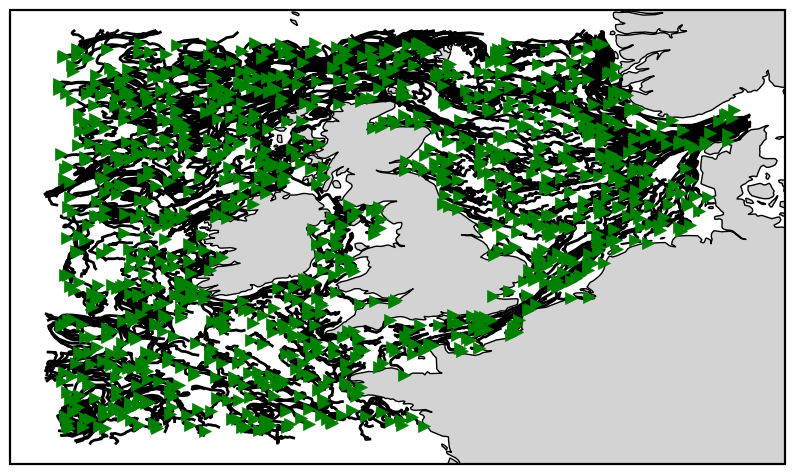

In [7]:
# plot selection of trajectories
year=2023
month=9

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(data[year][month]['lon_tracer'][0::50,0].values,
        data[year][month]['lat_tracer'][0::50,0].values,
        '>',
        color='green',
        zorder=20)
ax.plot(data[year][month]['lon_tracer'][0::50,0::24].values.T,
        data[year][month]['lat_tracer'][0::50,0::24].values.T,
        '-',
        color='black');


## Along track displacement

2023-09-01 00:00:00
2023-10-01 00:00:00


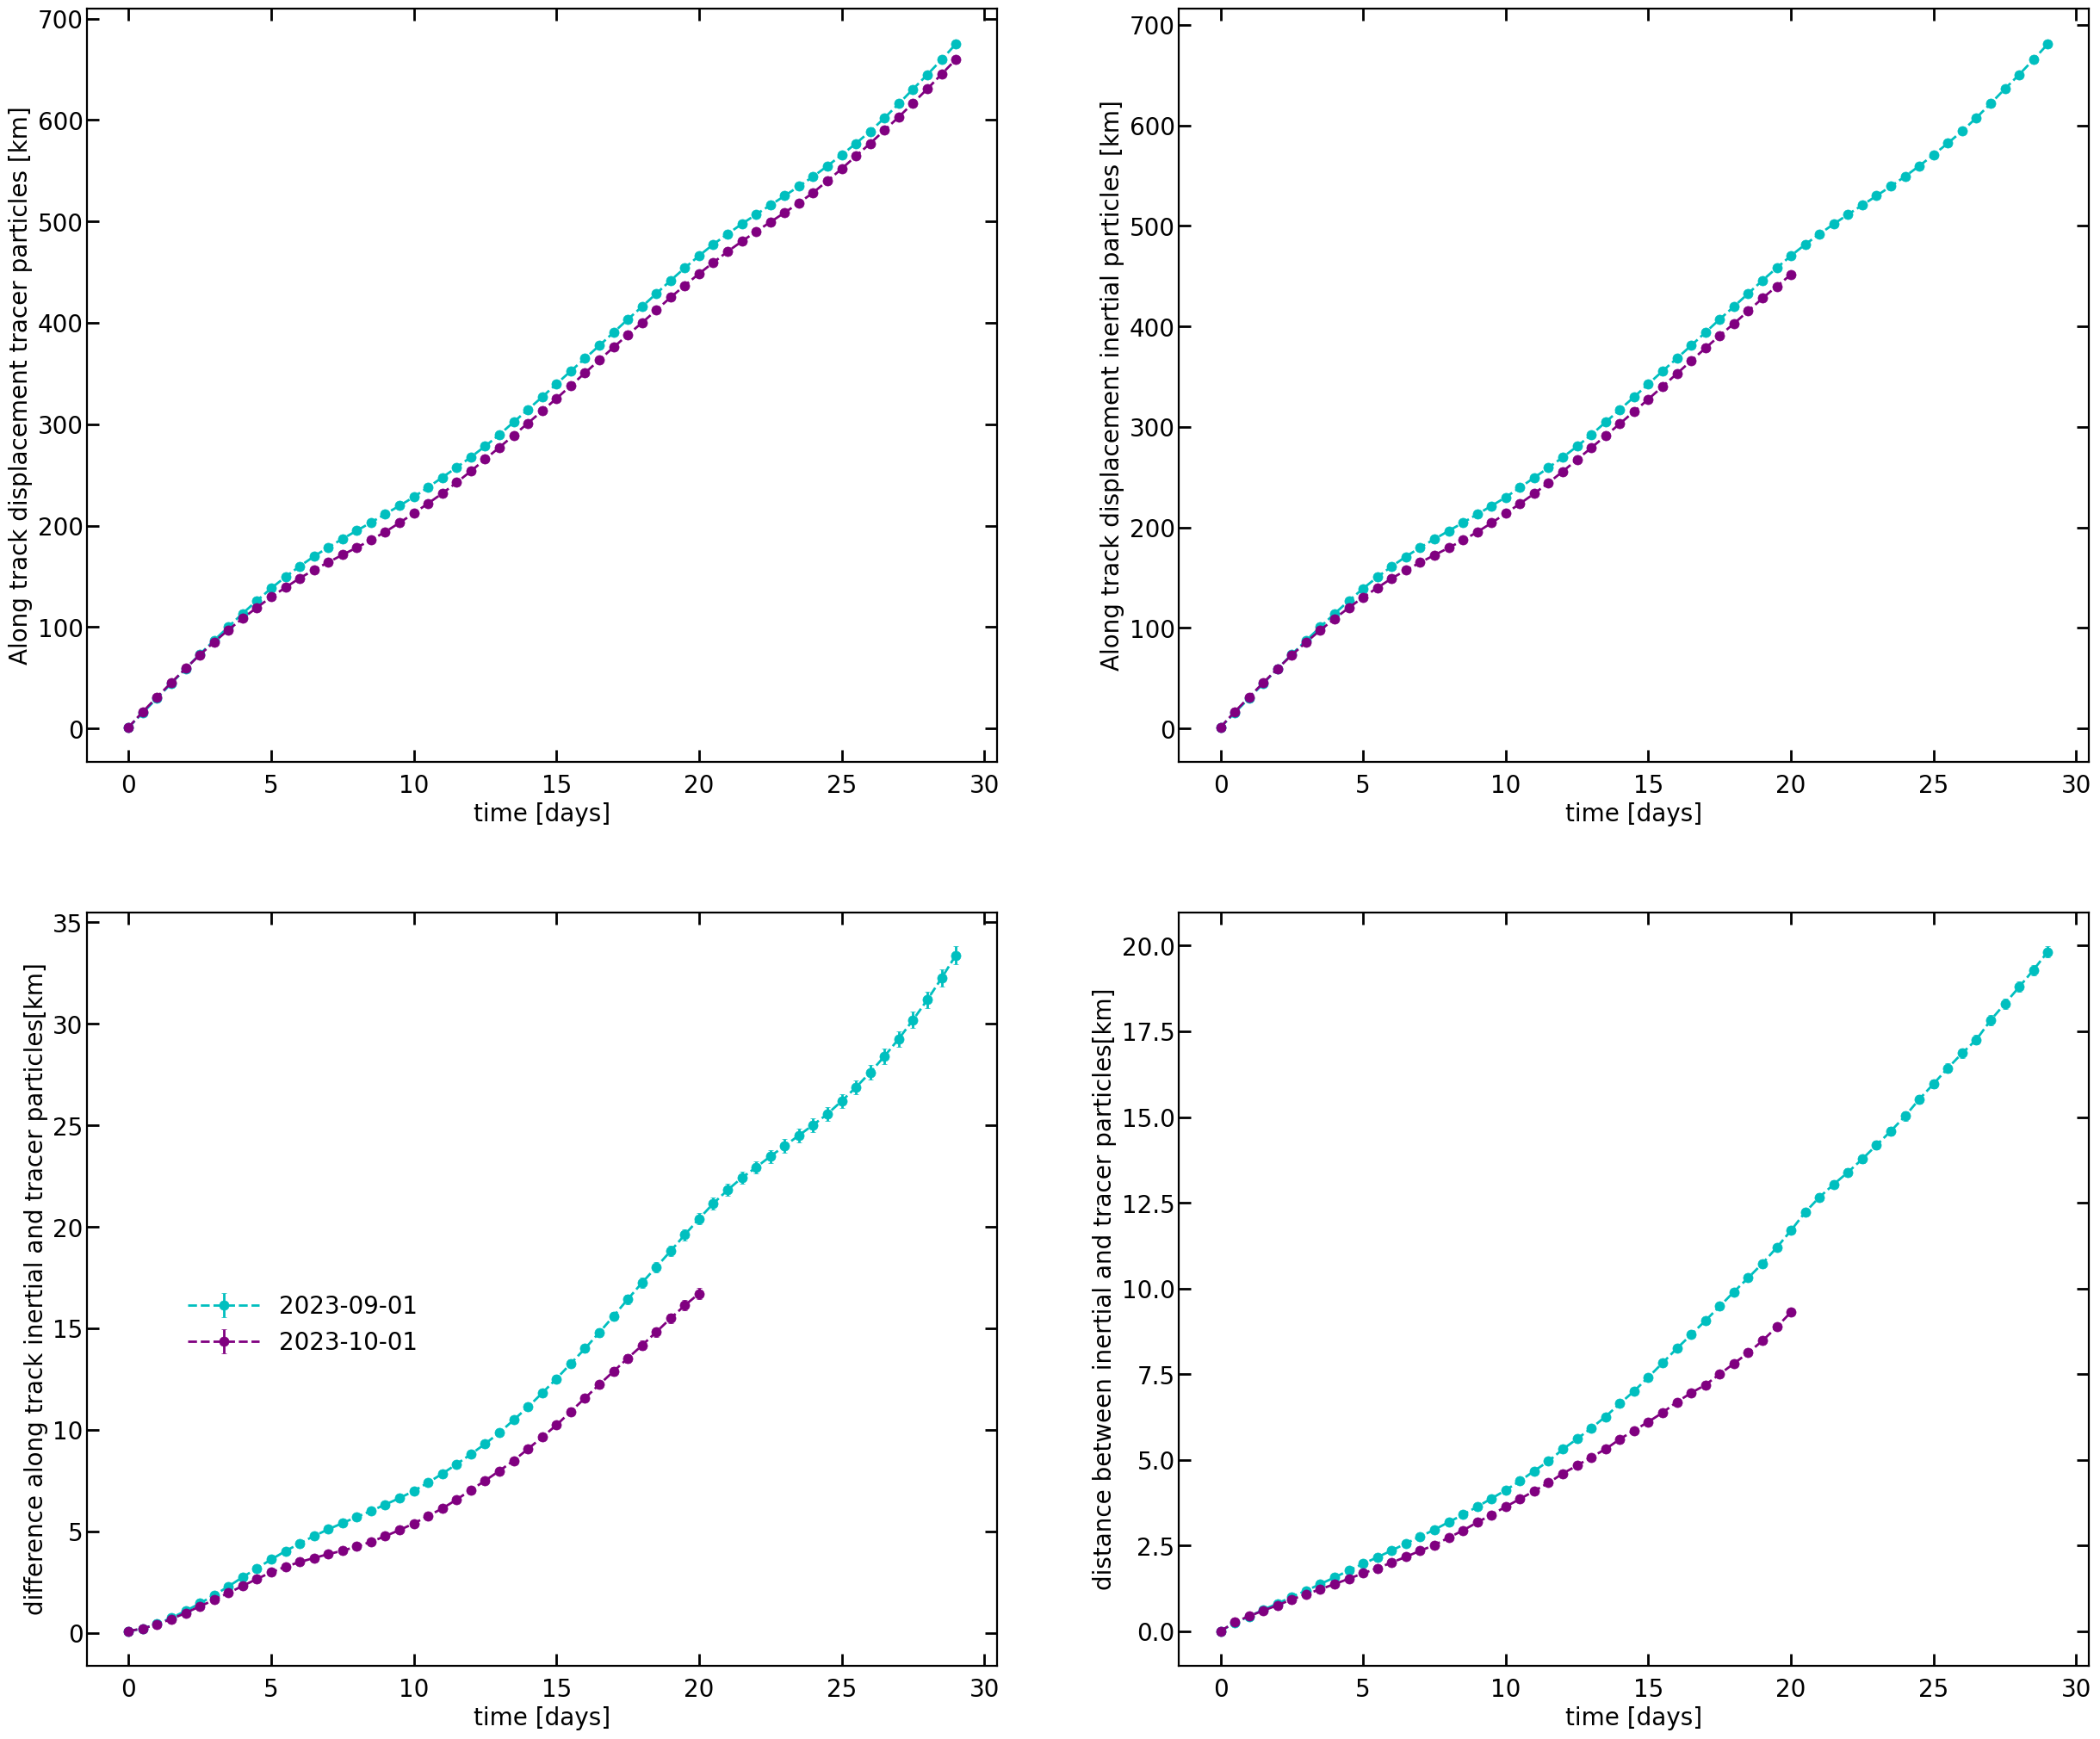

In [86]:
## along track displacement for entire region

fig,axs = plt.subplots(2,2,figsize=(30,25))
i=0
legend=[]
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    legend.append(f'{year}-{month:02d}-01')
    nanend=np.full((nparticles,1),np.nan)
    traj_tracer=trajectory_length(data[year][month]['lon_tracer'].values,
                                  data[year][month]['lat_tracer'].values)
    traj_tracer=np.concatenate((traj_tracer,nanend),axis=1)
    traj_MR=trajectory_length(data[year][month]['lon_MR'].values,data[year][month]['lat_MR'].values)
    traj_MR=np.concatenate((traj_MR,nanend),axis=1)
    diff_traj = np.fabs(traj_tracer - traj_MR)
    dist_tracer_MR = Haversine(data[year][month]['lon_tracer'],data[year][month]['lat_tracer'],
                               data[year][month]['lon_MR'], data[year][month]['lat_MR'])
    
    da_tracer = xr.DataArray(traj_tracer, dims=['trajectory','obs'])
    da_MR = xr.DataArray(traj_MR, dims=['trajectory','obs'])
    da_diff = xr.DataArray(diff_traj, dims=['trajectory','obs'])
    da_dist = xr.DataArray(dist_tracer_MR, dims=['trajectory','obs'])
    data[year][month]=data[year][month].assign(traj_tracer = da_tracer)
    data[year][month]=data[year][month].assign(traj_MR = da_MR)
    data[year][month]=data[year][month].assign(traj_diff = da_diff)
    data[year][month]=data[year][month].assign(dist_tracer_MR = da_dist)

    mean_tracer = data[year][month]['traj_tracer'].mean(dim='trajectory', skipna=True)
    mean_MR = data[year][month]['traj_MR'].mean(dim='trajectory', skipna=True)
    mean_diff = data[year][month]['traj_diff'].mean(dim='trajectory', skipna=True)
    mean_dist = data[year][month]['dist_tracer_MR'].mean(dim='trajectory', skipna=True)
    std_tracer = data[year][month]['traj_tracer'].std(dim='trajectory', skipna=True,ddof=1);
    std_MR = data[year][month]['traj_MR'].std(dim='trajectory', skipna=True,ddof=1);
    std_diff = data[year][month]['traj_diff'].std(dim='trajectory', skipna=True,ddof=1);
    std_dist = data[year][month]['dist_tracer_MR'].std(dim='trajectory', skipna=True,ddof=1);
    norm_tracer = data[year][month]['traj_tracer'].count(dim='trajectory')
    norm_MR = data[year][month]['traj_MR'].count(dim='trajectory')
    norm_diff = data[year][month]['traj_diff'].count(dim='trajectory')
    norm_dist = data[year][month]['dist_tracer_MR'].count(dim='trajectory')

    tmax=700
    tstep=12
    tlist=np.arange(0,tmax,tstep)/24
    axs[0,0].errorbar(tlist, mean_tracer[:tmax:tstep].values,
                      (std_tracer[:tmax:tstep]/np.sqrt(norm_tracer[:tmax:tstep])).values,
                      fmt='--o',color=colorlist[i])
    axs[0,1].errorbar(tlist, mean_MR[:tmax:tstep].values,
                      (std_MR[:tmax:tstep]/np.sqrt(norm_MR[:tmax:tstep])).values,
                      fmt='--o', color=colorlist[i])
    axs[1,0].errorbar(tlist, mean_diff[:tmax:tstep].values,
                      (std_diff[:tmax:tstep]/np.sqrt(norm_diff[:tmax:tstep])).values,
                      fmt='--o', color=colorlist[i])
    axs[1,1].errorbar(tlist, mean_dist[:tmax:tstep].values,
                      (std_dist[:tmax:tstep]/np.sqrt(norm_dist[:tmax:tstep])).values,
                      fmt='--o', color=colorlist[i])
    i+=1

axs[0,0].set_xlabel('time [days]')
axs[0,1].set_xlabel('time [days]')
axs[1,0].set_xlabel('time [days]')
axs[1,1].set_xlabel('time [days]')

axs[0,0].set_ylabel('Along track displacement tracer particles [km]')
axs[0,1].set_ylabel('Along track displacement inertial particles [km]')
axs[1,0].set_ylabel('difference along track inertial and tracer particles[km]')
axs[1,1].set_ylabel('distance between inertial and tracer particles[km]')

axs[1,0].legend(legend,loc=(0.1,0.4))


2023-09-01 00:00:00


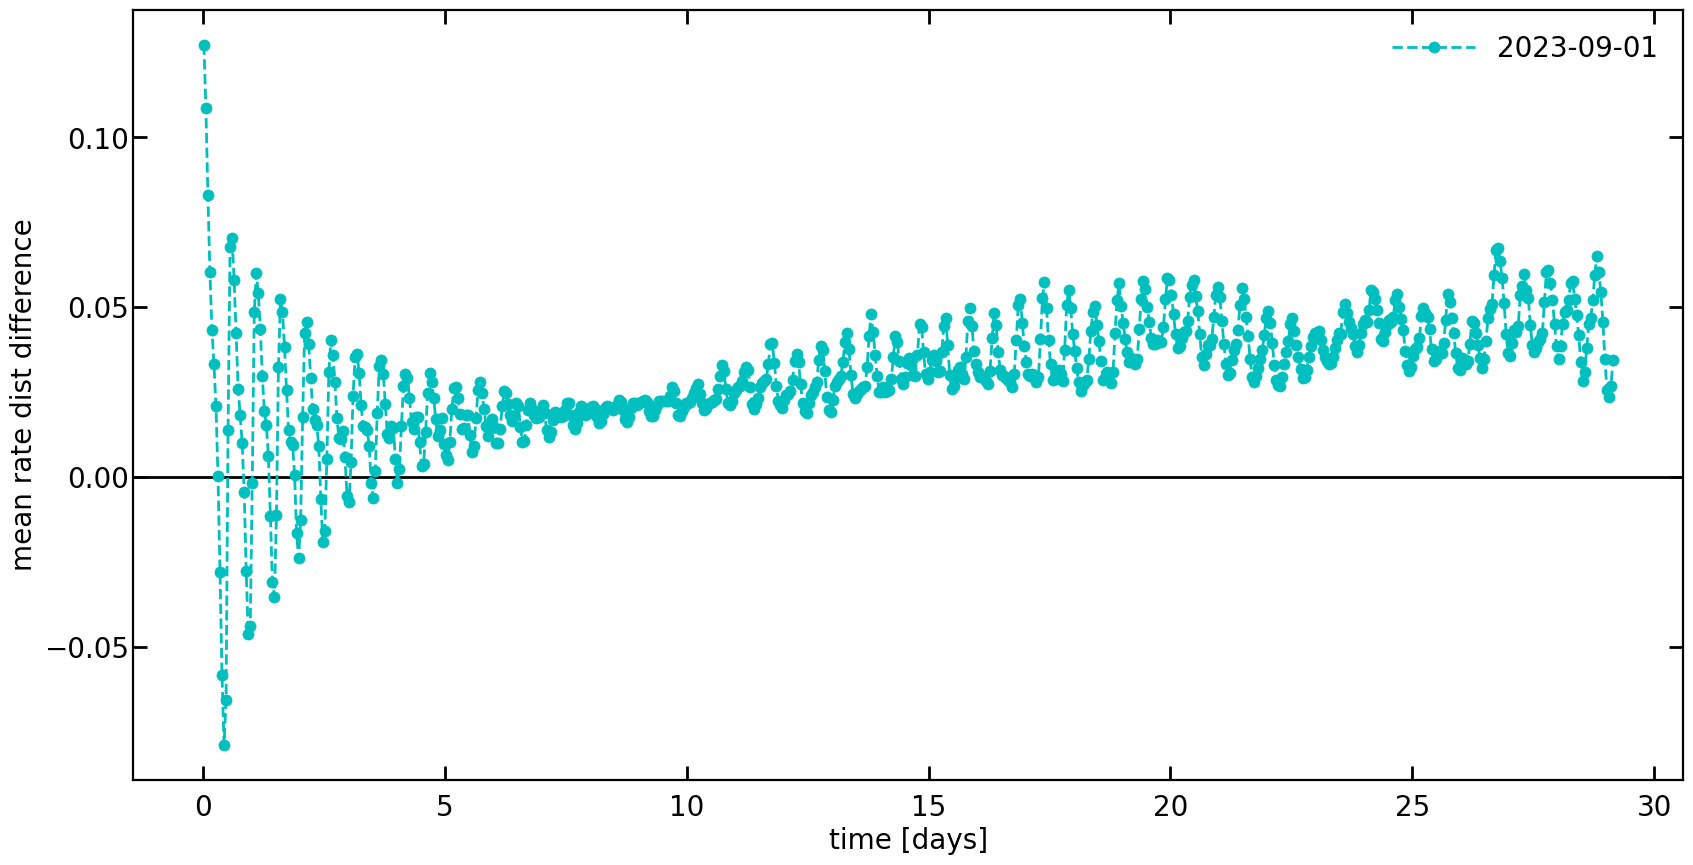

In [38]:
#plot difference rate (per hour)
i = 0 
tmax = 700
tstep = 1
fig,ax=plt.subplots(figsize=(20,10))
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    rate_dist = data[year][month].dist_tracer_MR.diff(dim='obs',n=1) # difference is 

    
    mean_rate_dist =rate_dist.mean(dim='trajectory', skipna=True)
    std_rate_dist = rate_dist.std(dim='trajectory', skipna=True,ddof=1);
    norm_rate_dist = data[year][month]['dist_tracer_MR'].count(dim='trajectory');
    tlist=np.arange(0,tmax,tstep)+0.5
    ax.plot(tlist/24, mean_rate_dist[:tmax:tstep].values,
                     '--o', color=colorlist[i])
    i+=1
    
ax.set_xlabel('time [days]')
ax.set_ylabel('mean rate dist difference')
ax.axhline(0,color='black',zorder=-20)
ax.legend(legend)
    
# note that first you see tidal signal (particles follow diferent trajectoreis through tide, but net deplacement purely to tide is zero because it is a periodic signal
# after approx 30 hours strong tidal signal is lost (however this is for entire region so probably selecting a subregion would make things different)

2023-09-01 00:00:00
fraction (dist > 10 km) = 0.4571


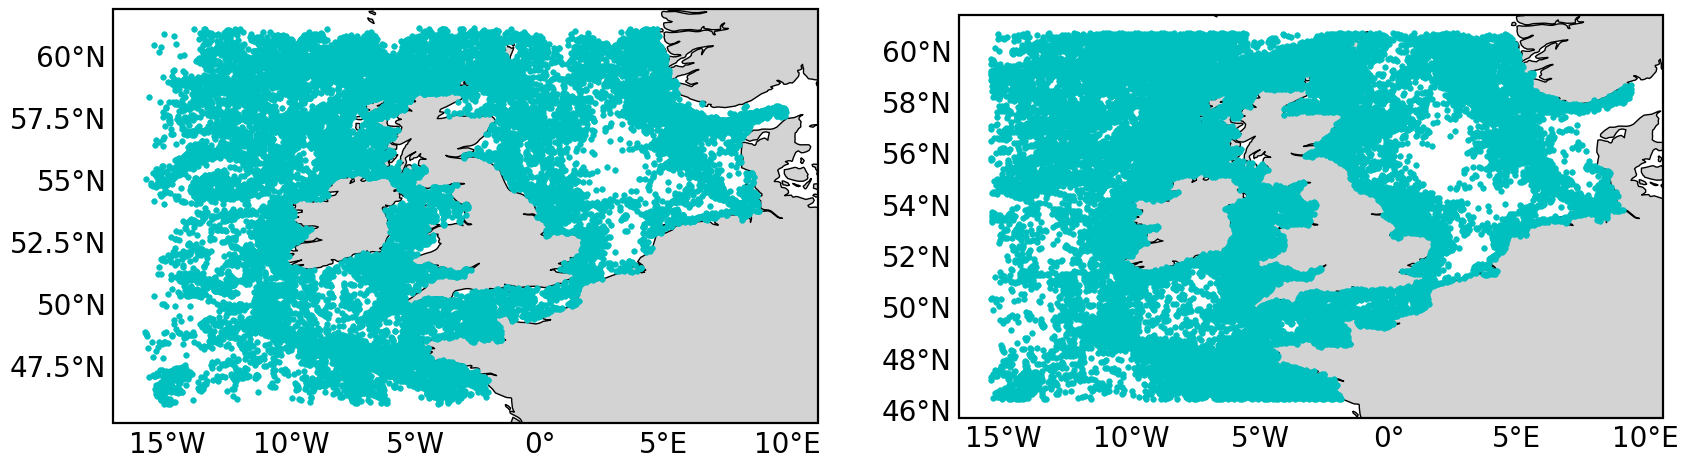

In [39]:
# plot trajectories particles when it is for the first time > cmax 

cmax = 10 # km
i=0
fig,axs=plt.subplots(1,2,figsize=(20,10),
                     subplot_kw={'projection':ccrs.PlateCarree()})
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # make dataset where only values where difference bigger than cmax are saved
    ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)

    first_lon = ds_cmax.lon_tracer.bfill(dim='obs')[:,0]
    first_lat = ds_cmax.lat_tracer.bfill(dim='obs')[:,0]
    #use bfill to plot first nonnan value
    axs[0].plot(first_lon, first_lat,'.',color=colorlist[i])
    
    select=~np.isnan(first_lon.values)  
    index_select = np.arange(0,nparticles,1)[select]

    start_lon = data[year][month].lon_tracer[select,0]
    start_lat = data[year][month].lat_tracer[select,0]
    axs[1].plot(start_lon,start_lat,'.',color=colorlist[i])



    ntotal=ds_cmax.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]
    print(f'fraction (dist > {cmax} km) = {ntotal/nparticles:.04f}')
    i+=1
axs[0].coastlines()
axs[0].add_feature(cart.feature.LAND,facecolor='lightgrey')
axs[1].coastlines()
axs[1].add_feature(cart.feature.LAND,facecolor='lightgrey')
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

# axs[0].set_xlim(-3,9.8)
# axs[0].set_ylim(50,61.5)
# axs[1].set_xlim(-3,9.8)
# axs[1].set_ylim(50,61.5)


2023-09-01 00:00:00
fraction (dist > 5 km) = 0.5931


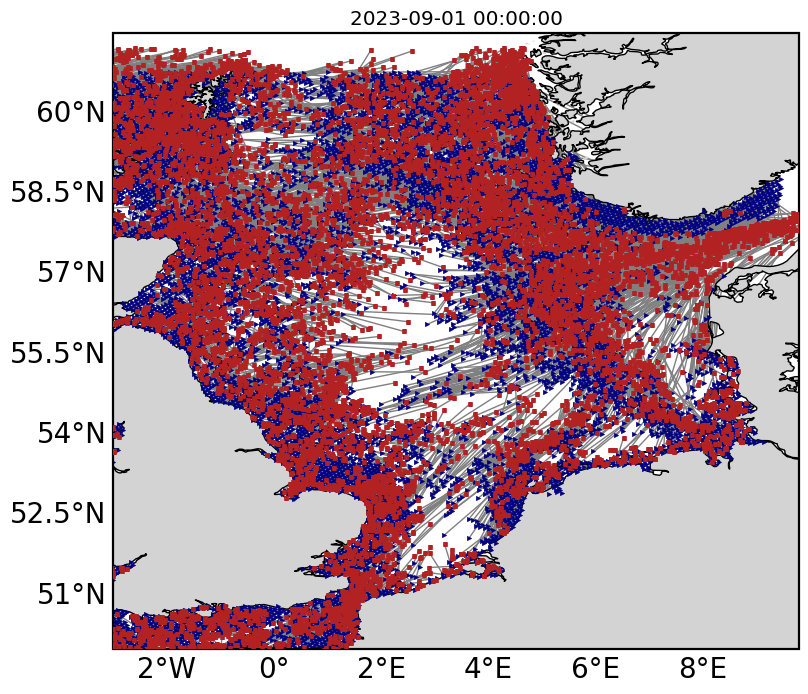

In [40]:
# plot trajectories particles when it is for the first time > cmax 

cmax = 5 #1 # 0.1 # km
i=0

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # make dataset where only values where difference bigger than cmax are saved
    ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)

    first_lon = ds_cmax.lon_tracer.bfill(dim='obs')[:,0]
    first_lon_p = first_lon.values#
    first_lon_p= first_lon_p[~np.isnan(first_lon_p)]
    first_lat = ds_cmax.lat_tracer.bfill(dim='obs')[:,0]
    first_lat_p = first_lat.values#
    first_lat_p =first_lat_p[~np.isnan(first_lat_p)]

    #use bfill to plot first nonnan value
    ax.plot(first_lon_p, first_lat_p,'s',color='firebrick',markersize=3,zorder=20)
    
    select=~np.isnan(first_lon.values)  
    index_select = np.arange(0,nparticles,1)[select]

    start_lon = data[year][month].lon_tracer[select,0]
    start_lat = data[year][month].lat_tracer[select,0]
    ax.plot(start_lon,start_lat,'>',color='navy',markersize=3)

    ax.plot(np.array([start_lon,first_lon_p]),np.array([start_lat, first_lat_p]),'-',color='grey',linewidth=1,zorder=-20)
    # print(start_lat.shape)
    # print(first_lat_p.shape)

    ntotal=ds_cmax.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]
    print(f'fraction (dist > {cmax} km) = {ntotal/nparticles:.04f}')
    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_xlim(-3,9.8)
    ax.set_ylim(50,61.5)
    ax.set_title(starttime)



2023-09-01 00:00:00


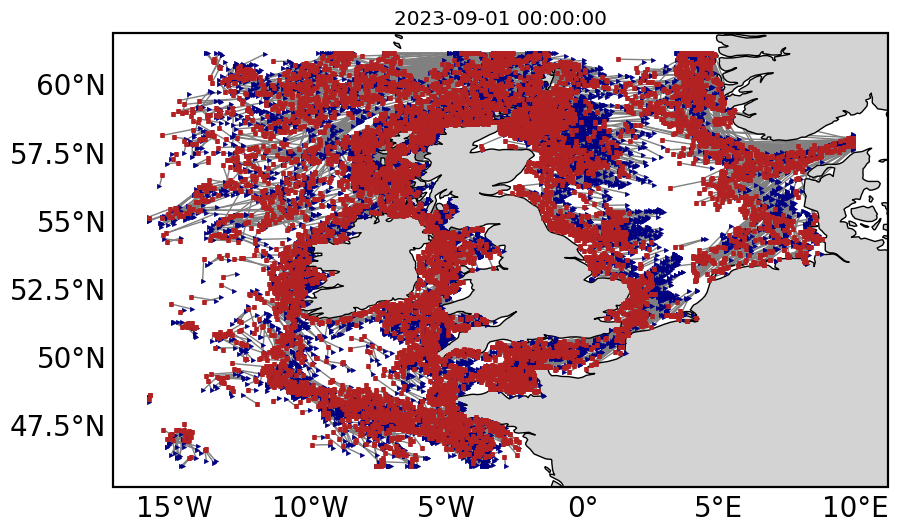

In [22]:
# plot trajectories particles when it is for the first time > cmax 

cmax = 10#0.5 #1 # 0.1 # km
i=0

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # final (non-nan) value of trajectory
    final_lon_MR = data[year][month].lon_MR.ffill(dim='obs')[:,-1].values
    final_lat_MR = data[year][month].lat_MR.ffill(dim='obs')[:,-1].values
    final_lon_tracer = data[year][month].lon_tracer.ffill(dim='obs')[:,-1].values
    final_lat_tracer = data[year][month].lat_tracer.ffill(dim='obs')[:,-1].values
    final_separation = data[year][month].dist_tracer_MR.ffill(dim='obs')[:,-1].values
    final_lon_MR = final_lon_MR[final_separation>cmax]
    final_lat_MR = final_lat_MR[final_separation>cmax]
    final_lon_tracer = final_lon_tracer[final_separation>cmax]
    final_lat_tracer = final_lat_tracer[final_separation>cmax]

    #use bfill to plot first nonnan value
    ax.plot(final_lon_MR, final_lat_MR,'s',color='firebrick',markersize=3,zorder=20)
    

    ax.plot(final_lon_tracer, final_lat_tracer,'>',color='navy',markersize=3)

    ax.plot(np.array([final_lon_tracer,final_lon_MR]),np.array([final_lat_tracer, final_lat_MR]),'-',color='grey',linewidth=1,zorder=-20)
    # print(start_lat.shape)
    # print(first_lat_p.shape)


  
    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    # ax.set_xlim(-3,9.8)
    # ax.set_ylim(50,61.5)
    ax.set_title(starttime)



2023-09-01 00:00:00


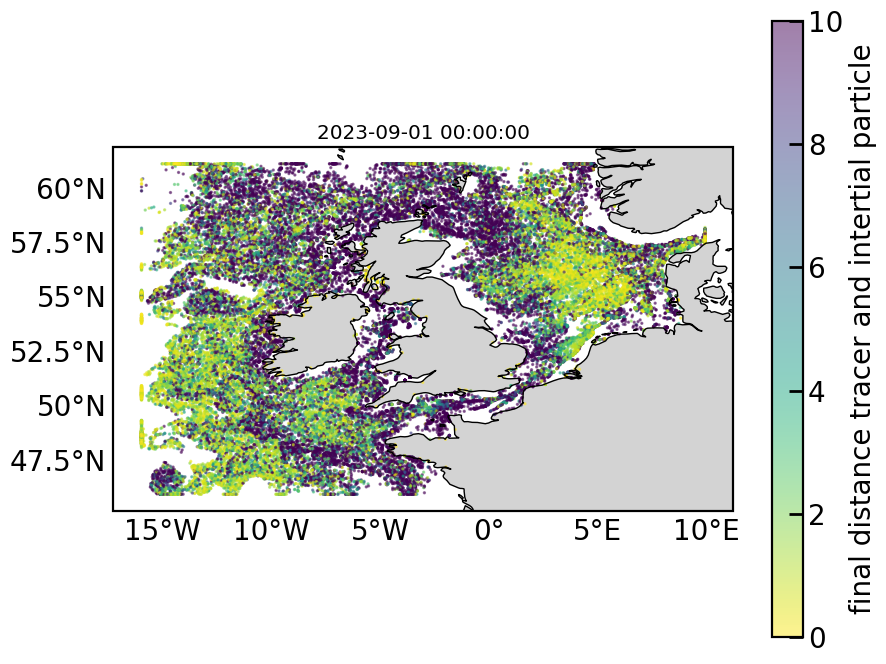

In [43]:
# scatter final position particle colored according to separation disance MR particle and tracer particle

# cmax = 10 #1 # 0.1 # km
i=0

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # final (non-nan) value of trajectory
    final_lon = data[year][month].lon_MR.ffill(dim='obs')[:,-1]
    final_lat = data[year][month].lat_MR.ffill(dim='obs')[:,-1]
    final_separation = data[year][month].dist_tracer_MR.ffill(dim='obs')[:,-1]
    #use bfill to plot first nonnan value
    sc=ax.scatter(final_lon, final_lat,s=2,c=final_separation,alpha=0.5,cmap='viridis_r',vmin=0,vmax=10)
    cxbar=fig.colorbar(sc,label='final distance tracer and intertial particle')
   

    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    # ax.set_xlim(-3,10)
    # ax.set_ylim(50,61.5)
    ax.set_title(starttime)



2023-09-01 00:00:00


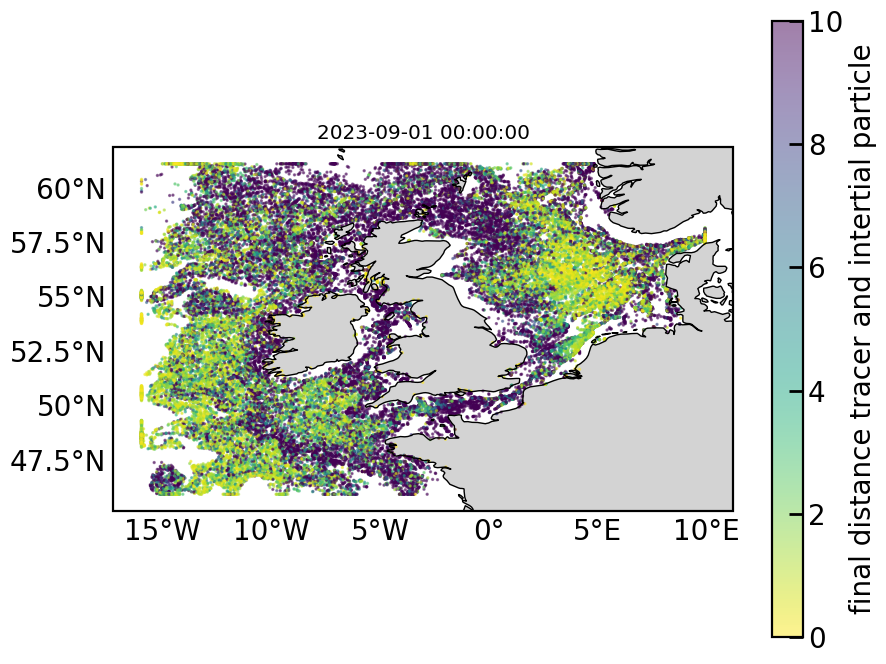

In [44]:
# scatter final position particle colored according to separation disance MR particle and tracer particle

# cmax = 10 #1 # 0.1 # km
i=0

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # final (non-nan) value of trajectory
    final_lon = data[year][month].lon_tracer.ffill(dim='obs')[:,-1]
    final_lat = data[year][month].lat_tracer.ffill(dim='obs')[:,-1]
    final_separation = data[year][month].dist_tracer_MR.ffill(dim='obs')[:,-1]
    #use bfill to plot first nonnan value
    sc=ax.scatter(final_lon, final_lat,s=2,c=final_separation,alpha=0.5,cmap='viridis_r',vmin=0,vmax=10)
    cxbar=fig.colorbar(sc,label='final distance tracer and intertial particle')
   

    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    # ax.set_xlim(-3,10)
    # ax.set_ylim(50,61.5)
    ax.set_title(starttime)



2023-09-01 00:00:00


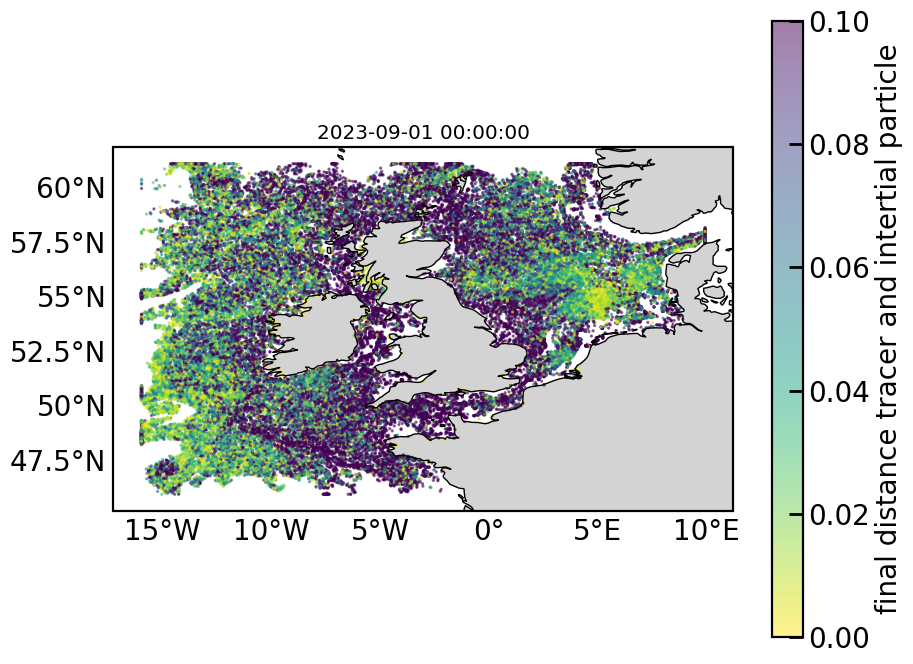

In [47]:
# plot trajectories particles when it is for the first time > cmax 

cmax = 1 #1 # 0.1 # km
i=0
tselect = 400

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # make dataset where only values where difference bigger than cmax are saved
    rate_dist = data[year][month].dist_tracer_MR.diff(dim='obs',n=1)[:,:tselect].ffill(dim='obs')[:,-1]
    final_lon = data[year][month].lon_tracer[:,:tselect].ffill(dim='obs')[:,-1]
    final_lat = data[year][month].lat_tracer[:,:tselect].ffill(dim='obs')[:,-1]

    
   
    #use bfill to plot first nonnan value
    sc=ax.scatter(final_lon, final_lat,s=2,c=np.fabs(rate_dist),alpha=0.5,cmap='viridis_r',vmin=0,vmax=0.1)
    cxbar=fig.colorbar(sc,label='final distance tracer and intertial particle')




    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    # ax.set_xlim(-3,10)
    # ax.set_ylim(50,61.5)
    ax.set_title(starttime)

2023-09-01 00:00:00


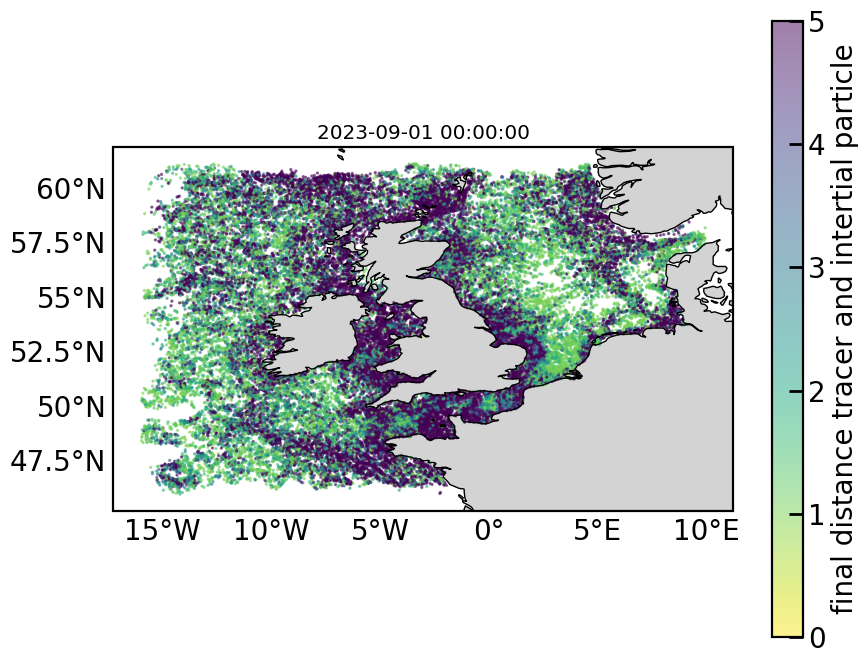

In [52]:
# plot trajectories particles when it is for the first time > cmax 

cmax = 1 #1 # 0.1 # km
i=0
tselect = 400

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)
    
    # make dataset where only values where difference bigger than cmax are saved
    rate_dist = ds_cmax.dist_tracer_MR[:,:tselect].ffill(dim='obs')[:,-1]
    final_lon = ds_cmax.lon_tracer[:,:tselect].bfill(dim='obs')[:,0]
    final_lat = ds_cmax.lat_tracer[:,:tselect].bfill(dim='obs')[:,0]

    
   
    #use bfill to plot first nonnan value
    sc=ax.scatter(final_lon, final_lat,s=2,c=np.fabs(rate_dist),alpha=0.5,cmap='viridis_r',vmin=0,vmax=5)
    cxbar=fig.colorbar(sc,label='final distance tracer and intertial particle')




    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    # ax.set_xlim(-3,10)
    # ax.set_ylim(50,61.5)
    ax.set_title(starttime)

In [86]:
data[year][month].dist_tracer_MR[:,-1].shape

(68476,)

IndexError: index 4 is out of bounds for axis 0 with size 1

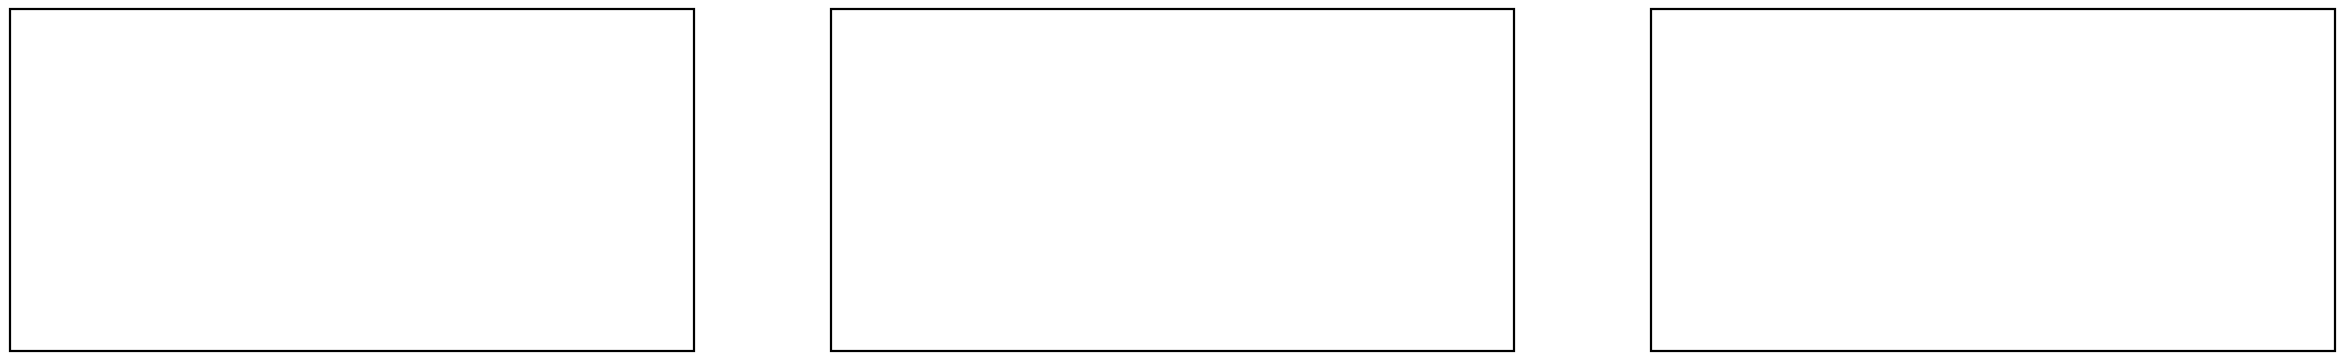

In [26]:
# plot trajectories particles when it is for the first time > cmax for specific month 

cmaxlist=np.array([0.01,0.1,1.0,10,100])
i=0
fig,axs=plt.subplots(1,3,figsize=(30,10),subplot_kw={'projection':ccrs.PlateCarree()})
j=2
startime= starttimes[4]
year = starttime.year
month = starttime.month
for cmax in cmaxlist:


    # make dataset where onlly values where difference bigger than cmax are saved
    ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)

    first_lon = ds_cmax.lon_tracer.bfill(dim='obs')[:,0]
    first_lat = ds_cmax.lat_tracer.bfill(dim='obs')[:,0]
    first_lon_MR = ds_cmax.lon_MR.bfill(dim='obs')[:,0]
    first_lat_MR = ds_cmax.lat_MR.bfill(dim='obs')[:,0]
    #use bfill to plot first nonnan value
    axs[0].plot(first_lon, first_lat,'.',color=colorlist[i])
    axs[1].plot(first_lon_MR, first_lat_MR,'.',color=colorlist[i])
    select=~np.isnan(first_lon.values)  
    index_select = np.arange(0,nparticles,1)[select]

    start_lon = data[year][month].lon_tracer[select,0]
    start_lat = data[year][month].lat_tracer[select,0]
    axs[2].plot(start_lon,start_lat,'.',color=colorlist[i])



    ntotal=ds_cmax.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]
    print(f'fraction (dist > {cmax} km) = {ntotal/nparticles:.04f}')
    i+=1
for p in range(0,3,1):
    axs[p].coastlines()
    axs[p].add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = axs[p].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}
    axs[p].set_xlim(-3,9.8)
    axs[p].set_ylim(50,61.5)


# axs[1].set_xlim(-3,9.8)
# axs[1].set_ylim(50,61.5)


Text(0.5, 1.0, 'Distribution of times when difference is for the first time > 1 km ')

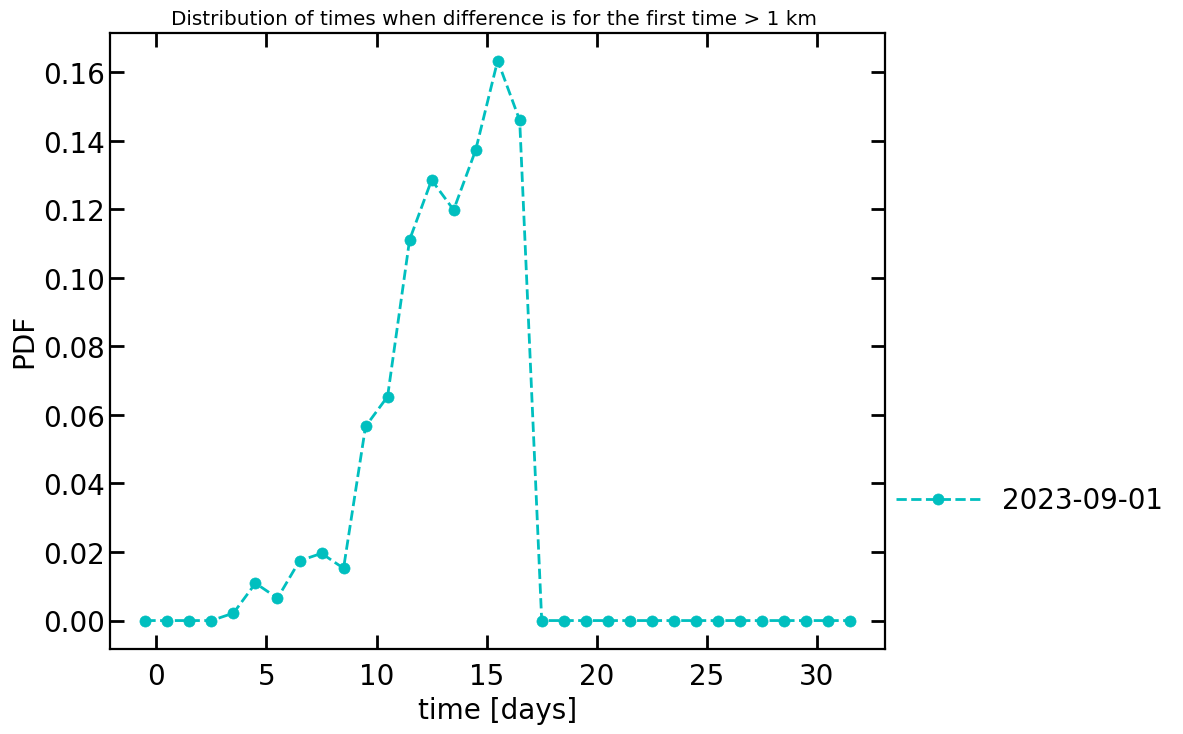

In [30]:
# trajectoreis of particles that at some point diviate more than cmax km 
cmax = 100 # km
i=0
fig,ax=plt.subplots()
# fig,axs=plt.subplots(1,2,figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
for starttime in starttimes:
    year = starttime.year
    month = starttime.month
        
    # make dataset where onlly values where difference bigger than cmax are saved
    ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)
    nspersecond=10**9
    first_time = ds_cmax.time_tracer.bfill(dim='obs')[:,0].values
    first_time = first_time[~np.isnan(first_time)]

    bins,pdf = make_PDF(first_time/3600/24,30,norm=True,min=0,max=30)
    ax.plot(bins,pdf,'--o',color=colorlist[i])
    i+=1
ax.legend(legend,loc=(1,0.2))

ax.set_xlabel('time [days]')
ax.set_ylabel('PDF')
ax.set_title('Distribution of times when difference is for the first time > 1 km ')


### When and where particles start to separate exactly?
Below I plot single tracectories of particles that start to separate more than 1km

52449


Text(0, 0.5, 'Distance between tracer and MR particle [km]')

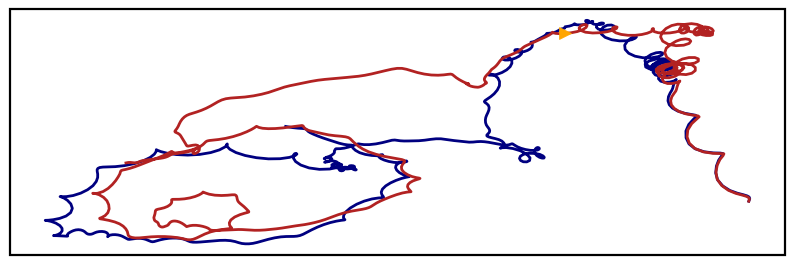

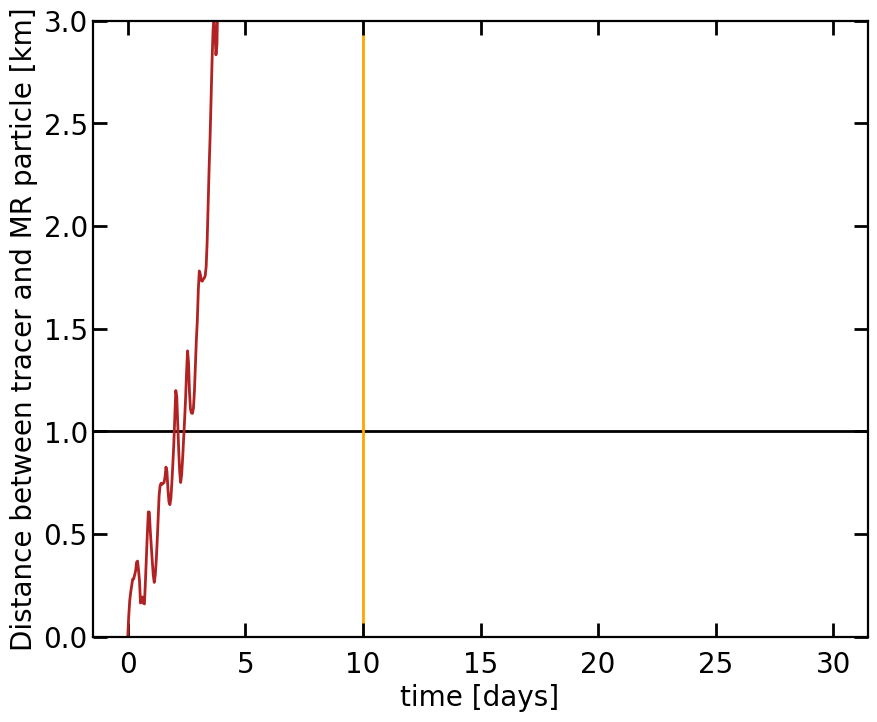

In [56]:
# trajectories of particles that at some point diviate more than 1 km 
i = 0 #november
starttime = starttimes[i]
year = starttime.year
month = starttime.month
cmax = 0.1 #km

#fig,ax=plt.subplots()
fig,ax=plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})


ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)

#use bfill to plot first nonnan value
first_lon = ds_cmax.lon_tracer.bfill(dim='obs')[:,0]
first_lat = ds_cmax.lat_tracer.bfill(dim='obs')[:,0]
select=~np.isnan(first_lon.values)  

index_select = np.arange(0,nparticles,1)[select]
print(index_select.size)

lon_tracer_select = data[year][month].lon_tracer.isel(trajectory=index_select)
lat_tracer_select = data[year][month].lat_tracer.isel(trajectory=index_select)
traj_tracer_select = data[year][month].traj_tracer.isel(trajectory=index_select)
lon_MR_select = data[year][month].lon_MR.isel(trajectory=index_select)
lat_MR_select = data[year][month].lat_MR.isel(trajectory=index_select)
traj_MR_select = data[year][month].traj_MR.isel(trajectory=index_select)
traj_diff_select = data[year][month].traj_diff.isel(trajectory=index_select)
dist_select = data[year][month].dist_tracer_MR.isel(trajectory=index_select)

pid= -1500 #700

ax.plot(lon_tracer_select[pid,:].T,lat_tracer_select[pid,:].T,color='navy')
ax.plot(lon_MR_select[pid,:].T,lat_MR_select[pid,:].T,color='firebrick')
ax.plot(lon_MR_select[pid,240].T,lat_MR_select[pid,240].T,'>',color='orange')
# ax.plot(lon_MR_select[pid,380].T,lat_MR_select[pid,380].T,'s',color='c')
ax.coastlines()
ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
# ax.set_xlim(-3,9.8)
# ax.set_ylim(50,61.5)

fig2,ax2=plt.subplots()


tlist=np.arange(0,720,1)
ax2.plot(tlist/24,dist_select[pid,:720],'-',color='firebrick')
ax2.axhline(1,color='black',zorder=-20)
ax2.axvline(240/24,color='orange',zorder=-10)
# ax2.axvline(390/24,color='c',zorder=-10)
ax2.set_ylim(0,3)
ax2.set_xlabel('time [days]')
ax2.set_ylabel('Distance between tracer and MR particle [km]')
# ax2.plot(tlist,dist_select[0,:700],'-',color='black')


start for loop
start for loop
start for loop


Text(0, 0.5, 'ratio ')

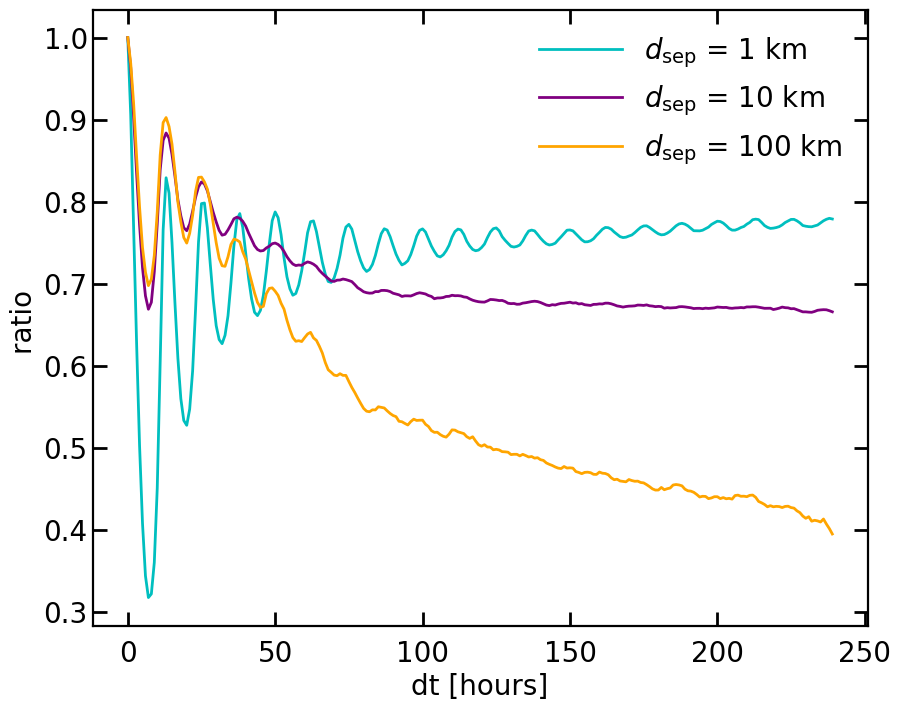

In [55]:
#n probability if dist is cmax at time t_cmax probability that after t_cmax + delta_t is > than cmax
# I think something with correlations
# 1) make list of 
i = 0 #november
starttime = starttimes[i]
year = starttime.year
month = starttime.month
cmaxlist=np.array([1,10,100])
fig,ax=plt.subplots()
j=0
legend_cmax = []
dTmax = 240
for cmax in cmaxlist:
    legend_cmax.append('$d_{\\mathrm{sep}}$ = ' + f'{cmax} km')
    count = np.zeros(dTmax)
    grow = np.zeros(dTmax)
    ratio = np.zeros(dTmax)
 
    ratio[0]=1

    time_cmax = data[year][month].time_tracer.where(data[year][month].dist_tracer_MR > cmax)
    first_time = time_cmax.bfill(dim='obs')[:,0].values
    select=~np.isnan(first_time)  
    start_time = first_time[select]
    index_select = np.arange(0,nparticles,1)[select]
    nparticles_cmax = index_select.size
    count[0]=nparticles_cmax
    grow[0]=nparticles_cmax

    ds_cmax = data[year][month].dist_tracer_MR.isel(trajectory=index_select)

    array = ds_cmax.values
    print('start for loop')
    m = 0
    for dt in range(1,dTmax,1):
        for n in range(0,nparticles_cmax,1):
            tstart = int(start_time[n]/3600)+dt
            if(tstart < 800):
                value = array[n,tstart]
                if(value != np.nan):
                    count[dt]+=1
                    if(value >= cmax):
                        grow[dt]+=1



    # print(test[3])
    ratio = 1.0 * grow / (1.0 * count)
    
    ax.plot(ratio,color=colorlist[j])

    j+=1
ax.legend(legend_cmax)
# axs[2].set_yscale('log')
ax.set_xlabel('dt [hours]')
ax.set_ylabel('ratio ')






KeyboardInterrupt: 

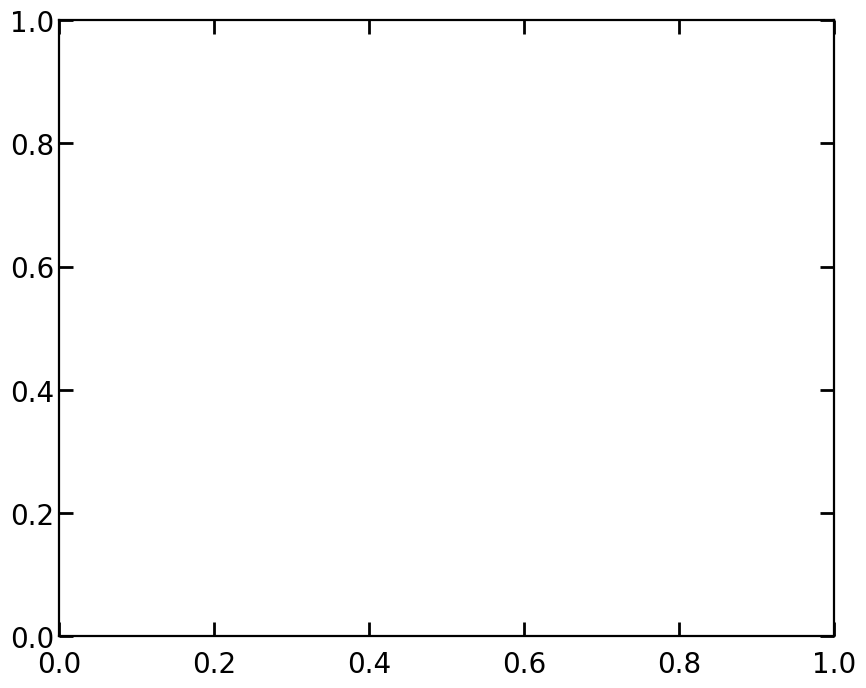

In [57]:
#n probability if dist is cmax at time t_cmax probability that after t_cmax + delta_t is > than cmax
# 1) make list of 
i = 0 #november
starttime = starttimes[i]
year = starttime.year
month = starttime.month
cmaxlist=np.array([1,10,100])
fig,ax=plt.subplots()
j=0
legend_cmax = []
dTmax = 24
for cmax in cmaxlist:
    legend_cmax.append('$d_{\\mathrm{sep}}$ = ' + f'{cmax} km')
    count = np.zeros(dTmax)
    grow = np.zeros(dTmax)
    ratio = np.zeros(dTmax)
 
    ratio[0]=1

    time_cmax = data[year][month].time_tracer.where(data[year][month].dist_tracer_MR > cmax)
    first_time = time_cmax.bfill(dim='obs')[:,0].values
    select=~np.isnan(first_time)  
    start_time = first_time[select]
    index_select = np.arange(0,nparticles,1)[select]
    nparticles_cmax = index_select.size
    ds_cmax = data[year][month].dist_tracer_MR.isel(trajectory=index_select)
    array = ds_cmax.values
    arr1=np.array(array[0,int(start_time[0]/3600):])
    arr1 = arr1[~np.isnan(arr1)]

    for n in range(1,nparticles_cmax):
        arr2=np.array(array[n,int(start_time[n]/3600):])
        arr2 = arr2[~np.isnan(arr2)]
        arr1 = np.concatenate((arr1,arr2))

    

    X, PDF = make_PDF(arr1,100,True)

    ax.plot(X,PDF,'--o',color=colorlist[j])
    j+=1
    
ax.legend(legend_cmax)
# axs[2].set_yscale('log')
ax.set_xlabel('Separation')
ax.set_ylabel('PDF ')
ax.set_xlim(0,2)






42008800
385367


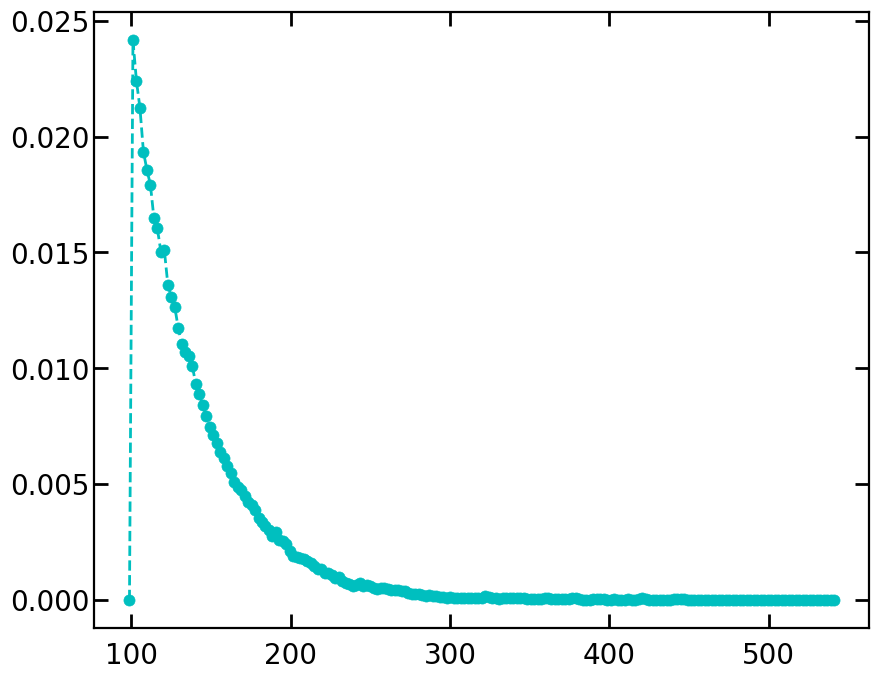

In [83]:
fig,ax=plt.subplots()
i=0
cmax=10
for starttime in starttimes:
    year=starttime.year
    month=starttime.month
    ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)
    
    array=ds_cmax.dist_tracer_MR[:,700].values.flatten()
    print(array.size)
    array=array[~np.isnan(array)]
    print(array.size)
    bins,pdf=make_PDF(array,nbins = 200, norm = True)
    ax.plot(bins,pdf,color=colorlist[i])
    i+=1
# ax.set_xlim(-1,10)

It seems that for specific months (November/December 2023) the effect of inertia is significant  
However if we select the particles for which the difference is significant (> 1km) we see that  
this are almost all coastal particles. Which suggests that this is an effect of the boundary  
conditions and not so much of the intertia of the particles.  
  
Below we select a fraction of the particles away from the boundary and see that the along  
track distance is the same for these particles.  

update (13 sept): If we look at the eulerian fields the biggest values of Du/Dt live at the  
coast, so it might not be the boundary condition but an actual feature! It would be good to  
test this for a different dataset that lives on a c-grid so there is no antibeaching current.   
However then we need to think about the derivatives at the coast still. We have the following options:  
1. calculate the derivative using the values at the boundaries of the gridcell (not sure how to implement)  
2. set derivatives in gridcell for coast to zero  


In [ ]:
# along track displacement for selection region 
fig,axs = plt.subplots(1,3,figsize=(30,10))
i=0
legend=[]
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    legend.append(f'{year}-{month:02d}-01')
    
    traj_tracer=trajectory_length(datatracer[year][month]['data']['lon'].values[select,:],datatracer[year][month]['data']['lon'].values[select,:])
    traj_MRSM=trajectory_length(dataMRSM[year][month]['data']['lon'].values[select,:],dataMRSM[year][month]['data']['lon'].values[select,:])
   
    diff_traj = np.fabs(traj_tracer - traj_MRSM)
    tlist=np.arange(0,24*10,1)/24

    tracer_number=np.zeros(24*10)
    tracer_values=np.zeros(24*10)
    tracer_error=np.zeros(24*10)

    MRSM_number=np.zeros(24*10)
    MRSM_values=np.zeros(24*10)
    MRSM_error=np.zeros(24*10)

    diff_number=np.zeros(24*10)
    diff_values=np.zeros(24*10)
    diff_error=np.zeros(24*10)

    for t in range(0,24*10,1):
        tracer_array=traj_tracer[:,t][~np.isnan(traj_tracer[:,t])]
        tracer_values[t]=np.mean(tracer_array)
        tracer_number[t]=tracer_array.size
        tracer_error[t]=np.std(tracer_array)

        MRSM_array=traj_MRSM[:,t][~np.isnan(traj_MRSM[:,t])]
        MRSM_values[t]=np.mean(MRSM_array)
        MRSM_number[t]=MRSM_array.size
        MRSM_error[t]=np.std(MRSM_array)

        diff_array=diff_traj[:,t][~np.isnan(diff_traj[:,t])]
        diff_values[t]=np.mean(diff_array)
        diff_number[t]=diff_array.size
        diff_error[t]=np.std(diff_array)


    axs[0].errorbar(tlist[::24],tracer_values[::24],tracer_error[::24]/np.sqrt(tracer_number[::24]),fmt='--o',color=colorlist[i])
    axs[1].errorbar(tlist[::24],MRSM_values[::24],MRSM_error[::24]/np.sqrt(MRSM_number[::24]),fmt='--o',color=colorlist[i])
    axs[2].errorbar(tlist[::24],diff_values[::24],diff_error[::24]/np.sqrt(diff_number[::24]),fmt='--o',color=colorlist[i])
    i+=1

axs[0].set_xlabel('time [days]')
axs[1].set_xlabel('time [days]')
axs[2].set_xlabel('time [days]')

axs[0].set_ylabel('Along track displacement tracer particles [km]')
axs[1].set_ylabel('Along track displacement inertial particles [km]')
axs[2].set_ylabel('diffrence inertial and tracer particles[km]')
# axs[0].text(0,1000,'(a)',fontsize=30)
# axs[1].text(0,1000,'(b)',fontsize=30)
# axs[2].text(0,5,'(c)',fontsize=30)
axs[2].legend(legend,loc=(0.1,0.4))
# axs[2].set_yscale('log')
# axs[2].set_xscale('log')
#  print(trajectories[1000,-1])
# traj_length_mean=np.mean(trajectories,axis=0)
# traj_length_sd=np.std(trajectories,axis=0)

# fig,ax=plt.
# 
# subplots()
# i=0
# tlist=np.arange(0,traj_length_mean.size,1)
# ax.errorbar(tlist,traj_length_mean,traj_length_sd,fmt='--o',color='navy')
# ax.legend(starttimes)

# # #ax.set_title(season+' '+year,fontsize=20)
# ax.set_ylabel('Along track displacement [km]')

(68476,)
(68476,)
(68476,)
(68476,)
(68476,)
(68476,)


(0.0, 0.02)

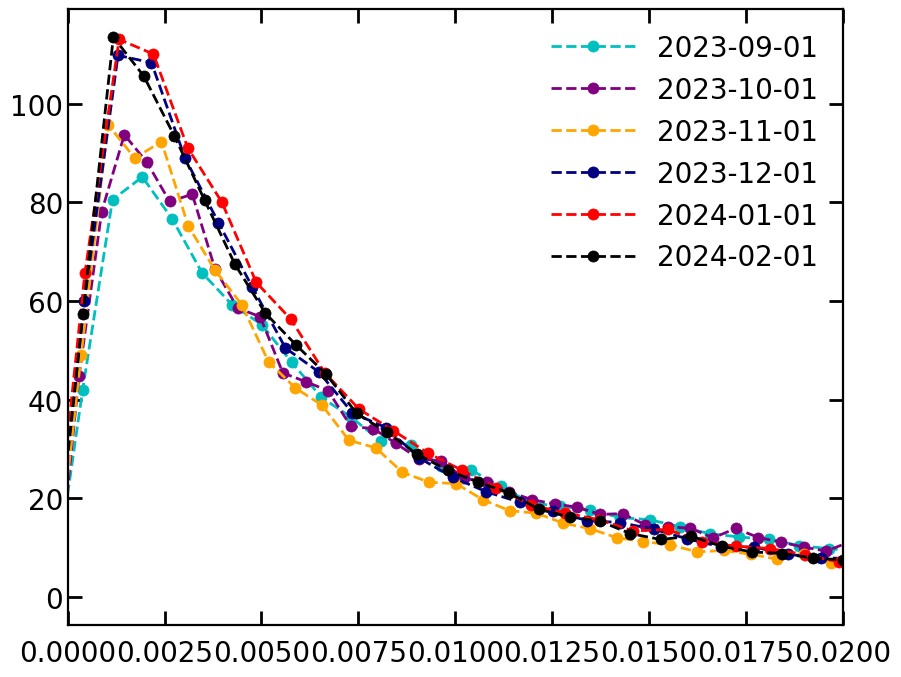

In [7]:
# make pdf, log-normal distirbution? 
# for good statistics I think you should only compare 1 timestep and not all timesteps
# TO DO: make a pdf that does logaritmic scaling
i=0
fig,ax=plt.subplots()
legend=[]
for starttime in starttimes:

    year = starttime.year
    month = starttime.month
    legend.append(f'{year}-{month:02d}-01')

    array = data[year][month]['dist_tracer_MR'][:,700].values
    print(array.shape)
    array = array[~np.isnan(array)]

    X, PDF = make_PDF(array,500000,True)

    ax.plot(X[0:],PDF[0:],'--o',color=colorlist[i])
        
    i+=1
ax.legend(legend)
# ax.set_xscale('log')
xtest=np.logspace(-3,2,100)
# ax.plot(xtest[0:],np.exp(-(xtest[:]/0.005)**(1)),'-',color='green')
# ax.set_xlim(0.2,0.4)
# ax.set_ylim(0,1)
ax.set_xlim(0,0.02)

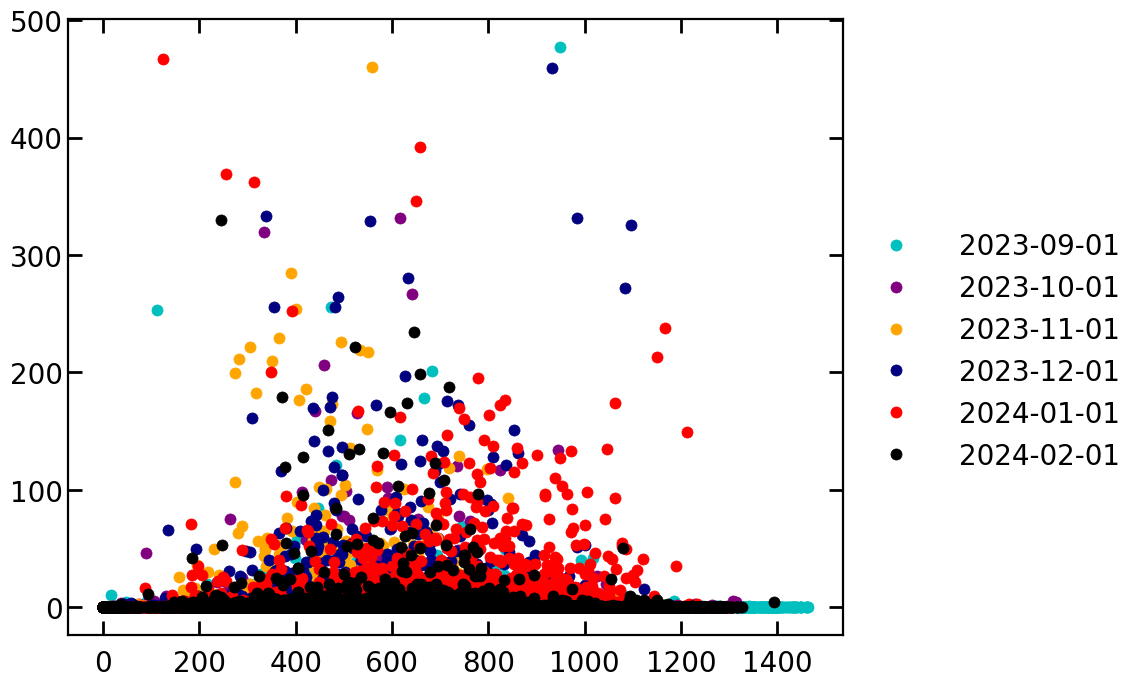

In [9]:
# make pdf
i=0
fig,ax=plt.subplots()
legend=[]
for starttime in starttimes:

    year = starttime.year
    month = starttime.month
    legend.append(f'{year}-{month:02d}-01')

    ax.plot(dataMRSM[year][month]['traj'][:,300],dataMRSM[year][month]['diff_traj'][:,300],'o',color=colorlist[i])

    i+=1
ax.legend(legend,loc=(1,0.25))


In [13]:
np.mean(dataMRSM[year][month]['diff_traj'][:,200][~np.isnan(dataMRSM[year][month]['diff_traj'][:,200])])

0.04044389

In [ ]:
# make better plots at some point, also consider to analyse only doggersbank particles
i=0
starttime=starttimes[i]
print(starttime)
year = starttime.year
month = starttime.month
values=[]
tmaxlist=[]
b = (~np.isnan(dataMRSM[year][month]['diff_traj'])).cumsum(1).argmax(1)

c=dataMRSM[year][month]['diff_traj'][ np.arange(dataMRSM[year][month]['diff_traj'].shape[0]),b]
fig,ax=plt.subplots()
lon = dataMRSM[year][month]['data']['lon'][:,0].values[select]#[~np.isnan(dataMRSM[year][month]['data']['lon'][0].values)]
lat = dataMRSM[year][month]['data']['lat'][:,0].values[select]


plot = ax.scatter(lon,lat,s=10, c = c, norm=colors.LogNorm())
fig.colorbar(plot)
    


In [ ]:
# make animation of trajectories of particles that deviate more than 1 km 

i = 3
starttime=starttimes[i]
year = starttime.year
month = starttime.month
values=[]
tmaxlist=[]
b = (~np.isnan(dataMRSM[year][month]['diff_traj'])).cumsum(1).argmax(1)

c=dataMRSM[year][month]['diff_traj'][ np.arange(dataMRSM[year][month]['diff_traj'].shape[0]),b]
fig,ax=plt.subplots()
lon = dataMRSM[year][month]['data']['lon'][select,0].values[c>1]#[~np.isnan(dataMRSM[year][month]['data']['lon'][0].values)]
lat = dataMRSM[year][month]['data']['lat'][select,0].values[c>1]


plot = ax.scatter(lon,lat,s=100, c = c[c>1], norm=colors.LogNorm())
fig.colorbar(plot)
    

In [ ]:
if(np.nan > 5):
    print('true')
else:
    print('false')

In [ ]:

# make better plots at some point, also consider to analyse only doggersbank particles
i=2
starttime=starttimes[i]
print(starttime)
year = starttime.year
month = starttime.month
values=[]
tmaxlist=[]
array=dataMRSM[year][month]['diff_traj'][:,700]
b = (~np.isnan(dataMRSM[year][month]['diff_traj'])).cumsum(1).argmax(1)

c=dataMRSM[year][month]['diff_traj'][ np.arange(dataMRSM[year][month]['diff_traj'].shape[0]),b]
lon = dataMRSM[year][month]['data']['lon'][:,0].values[~np.isnan(array)]
lat = dataMRSM[year][month]['data']['lat'][:,0].values[~np.isnan(array)]
lontracer=datatracer[year][month]['data']['lon'][c<0.1,:]
lattracer=datatracer[year][month]['data']['lat'][c<0.1,:]

lonMRSM=dataMRSM[year][month]['data']['lon'][c<0.1,:]
latMRSM=dataMRSM[year][month]['data']['lat'][c<0.1,:]

fig,ax=plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
tmax=699
ax.plot(lontracer[::1,:tmax+1:1].T, lattracer[::1, :tmax+1:1].T, color='black')
ax.plot(lontracer[::1,0].T, lattracer[::1,0].T, '>', color='green',zorder=20)
ax.plot(lonMRSM[::1, :tmax+1:1].T, latMRSM[::1, :tmax+1:1].T,':', color='grey')


# array= array[~np.isnan(array)]





# plot = ax.scatter(lon[array>5],lat[array>5],s=1, c = array[array>5], norm=colors.LogNorm())
# fig.colorbar(plot)
    
